![](https://www.suhakki.org/wp-content/uploads/2016/08/desalinasyon-1280.jpg)

In [1]:
import numpy as np 
import pandas as pd
import plotly as py
import plotly.graph_objs as go
import plotly.express as px
from plotly.offline import init_notebook_mode
init_notebook_mode(connected = True)
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, accuracy_score

from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.model_selection import StratifiedKFold, KFold

import optuna

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

pd.set_option('display.max_columns', None)
#########################################################
water = pd.read_csv('../input/water-potability/water_potability.csv')

**Water quality** refers to the chemical, physical, and biological characteristics of water based on the standards of its usage. It is most frequently used by reference to a set of standards against which compliance, generally achieved through treatment of the water, can be assessed. The most common standards used to monitor and assess water quality convey the health of ecosystems, safety of human contact, and condition of drinking water. Water quality has a significant impact on water supply and oftentimes determines supply options.

# Basic information

In [2]:
water.head(3)

ph    Hardness        Solids  Chloramines     Sulfate  Conductivity  \
0       NaN  204.890455  20791.318981     7.300212  368.516441    564.308654   
1  3.716080  129.422921  18630.057858     6.635246         NaN    592.885359   
2  8.099124  224.236259  19909.541732     9.275884         NaN    418.606213   

   Organic_carbon  Trihalomethanes  Turbidity  Potability  
0       10.379783        86.990970   2.963135           0  
1       15.180013        56.329076   4.500656           0  
2       16.868637        66.420093   3.055934           0

In [3]:
water.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


**Features description:**

1. **ph** - the acid–base balance of water. WHO has recommended maximum permissible limit of pH from 6.5 to 8.5. The current investigation ranges were 6.52–6.83 which are in the range of WHO standards. At pH=7, the water is neutral, at pH less than 7 — acidic, at pH more than 7 — alkaline.

2. **Hardness** - mainly caused by calcium and magnesium salts. General guidelines for classification of waters are: 0 to 60 mg/L (milligrams per liter) as calcium carbonate is classified as soft; 61 to 120 mg/L as moderately hard; 121 to 180 mg/L as hard; and more than 180 mg/L as very hard.

3. **Solids** - water has the ability to dissolve a wide range of inorganic and some organic minerals or salts such as potassium, calcium, sodium, bicarbonates, chlorides, magnesium, sulfates etc. These minerals produced un-wanted taste and diluted color in appearance of water. This is the important parameter for the use of water. The water with high TDS value indicates that water is highly mineralized. Desirable limit for TDS is 500 mg/l and maximum limit is 1000 mg/l which prescribed for drinking purpose.

4. **Chloramines** - chlorine and chloramine are the major disinfectants used in public water systems. Chloramines are most commonly formed when ammonia is added to chlorine to treat drinking water. Chlorine levels up to 4 milligrams per liter (mg/L or 4 parts per million (ppm)) are considered safe in drinking water.

5. **Sulfate** - sulfates are naturally occurring substances that are found in minerals, soil, and rocks. Sulfate concentration in seawater is about 2,700 milligrams per liter (mg/L). It ranges from 3 to 30 mg/L in most freshwater supplies, although much higher concentrations (1000 mg/L) are found in some geographic locations.

6. **Conductivity** - pure water is not a good conductor of electric current rather’s a good insulator. Increase in ions concentration enhances the electrical conductivity of water. Generally, the amount of dissolved solids in water determines the electrical conductivity. Electrical conductivity (EC) actually measures the ionic process of a solution that enables it to transmit current. According to WHO standards, EC value should not exceeded 400 μS/cm.

7. **Organic_carbon** - total Organic Carbon (TOC) in source waters comes from decaying natural organic matter (NOM) as well as synthetic sources. TOC is a measure of the total amount of carbon in organic compounds in pure water. According to US EPA < 2 mg/L as TOC in treated / drinking water, and < 4 mg/Lit in source water which is use for treatment.

8. **Trihalomethanes** - THMs are chemicals which may be found in water treated with chlorine. The concentration of THMs in drinking water varies according to the level of organic material in the water, the amount of chlorine required to treat the water, and the temperature of the water that is being treated. The legal limit of total THMs in drinking water in Europe is 100 ppm.

9. **Turbidity** - the turbidity of water depends on the quantity of solid matter present in the suspended state. It is a measure of light emitting properties of water and the test is used to indicate the quality of waste discharge with respect to colloidal matter. The mean turbidity value obtained for Wondo Genet Campus (0.98 NTU) is lower than the WHO recommended value of 5.00 NTU.

10. **Potability** - indicates if water is safe for human consumption where 1 means Potable and 0 means Not potable.

# Preprocessing for EDA

What is the main idea of how I will recover the missing values - we have all the data on water hardness and total dissolved solids in water, and I will take for the missing values the average of other observations whose values in hardness and solids do not differ by more than +-10% from the values of the observation with the missing value. I will replace the remaining missing values with the general average, there will be a few of them and this should not greatly affect the construction of models.

In [4]:
for f in ['ph', 'Sulfate', 'Trihalomethanes']:
    for i in range(len(water)):
        if pd.isna(water[f][i]) == True:
            hardna = water['Hardness'][i]
            solidna = water['Solids'][i]
            water[f][i] = water.query("(Hardness > @hardna * 0.9 & Hardness < @hardna * 1.1) & (Solids > @solidna * 0.9 & Solids < @solidna * 1.1)")[f].mean()

Due to the small data, no more than 10 observations were not recovered by this method. In them, I'll just insert the overall averages for their columns. If there were more data, then for a more accurate recovery, I could take not 2, but 3 features, and also take not 10% of the span, but 5%.

In [5]:
for i in ['ph', 'Sulfate', 'Trihalomethanes']:
    water[i].fillna(water[i].mean(), inplace = True)

# EDA

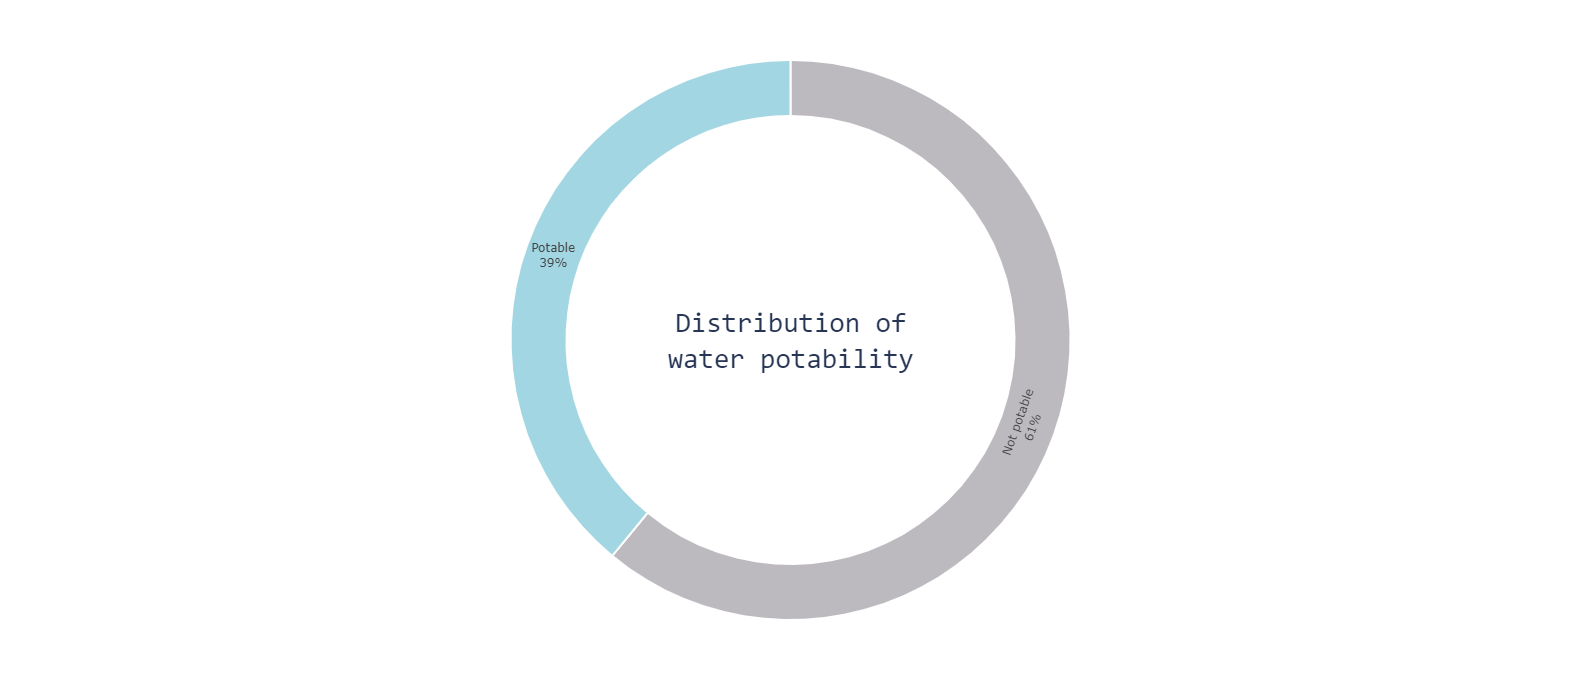

In [6]:
repotability = {0: 'Not potable', 1: 'Potable'}
water['Potability'] = water['Potability'].map(repotability)

fig = px.pie(water['Potability'].value_counts().reset_index(), values = 'Potability', names = 'index', width = 700, height = 700)
fig.update_traces(textposition = 'inside', 
                  textinfo = 'percent + label', 
                  hole = 0.8, 
                  marker = dict(colors = ['#bcbabe','#a1d6e2'], line = dict(color = 'white', width = 2)))

fig.update_layout(annotations = [dict(text = ' Distribution of <br>water potability', 
                                      x = 0.5, y = 0.5, font_size = 28, showarrow = False, 
                                      font_family = 'monospace',
                                      font_color = '#283655')],
                  showlegend = False)
                  
fig.show()

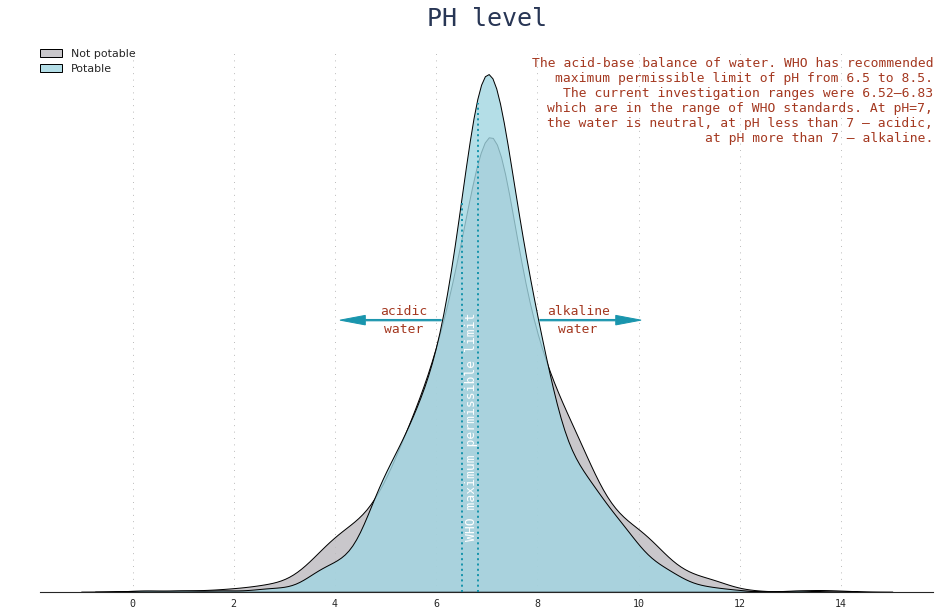

In [8]:
plt.figure(figsize = (16, 10))
sns.set_style("white")
plt.title('PH level', size = 25, y = 1.03, fontname = 'monospace', color = '#283655')
plt.grid(color = 'gray', linestyle = ':', axis = 'x', alpha = 0.8, zorder = 0,  dashes = (1,7))
a = sns.kdeplot(water.query("Potability == 'Not potable'")['ph'], color = '#bcbabe', shade = True, label = 'Not potable', alpha = 0.8, linewidth = 1, edgecolor = 'black')
sns.kdeplot(water.query("Potability == 'Potable'")['ph'], color = '#a1d6e2', shade = True, label = 'Potable', alpha = 0.8, linewidth = 1, edgecolor = 'black')
plt.ylabel('')
plt.xlabel('')
plt.xticks(fontname = 'monospace')
plt.yticks([])
plt.legend(['Not potable', 'Potable'], bbox_to_anchor = (0.15, 1.07), ncol = 1, borderpad = 3, frameon = False, fontsize = 11)

a.axvline(x = 6.52, linestyle = ':', color = '#1995ad', ymin = 0, ymax = 0.72, lw = 2)
a.axvline(x = 6.83, linestyle = ':', color = '#1995ad', ymin = 0, ymax = 0.9, lw = 2)
a.arrow(6.1, 0.2, -1.5, 0, width = 0.001, head_width = 0.007, head_length = 0.5, color = '#1995ad')
a.arrow(8.05, 0.2, 1.5, 0, width = 0.001, head_width = 0.007, head_length = 0.5, color = '#1995ad')

for j in ['right', 'left', 'top']:
        a.spines[j].set_visible(False)
a.spines['bottom'].set_linewidth(1.1)

plt.figtext(0.494, 0.2, 'WHO maximum permissible limit', fontsize = 13, fontname = 'monospace', color = 'white', rotation = 90)
plt.figtext(0.42, 0.51, 'acidic', fontsize = 13, fontname = 'monospace', color = '#a43820')
plt.figtext(0.423, 0.485, 'water', fontsize = 13, fontname = 'monospace', color = '#a43820')
plt.figtext(0.565, 0.51, 'alkaline', fontsize = 13, fontname = 'monospace', color = '#a43820')
plt.figtext(0.574, 0.485, 'water', fontsize = 13, fontname = 'monospace', color = '#a43820')
plt.figtext(0.9, 0.75, '''The acid-base balance of water. WHO has recommended
maximum permissible limit of pH from 6.5 to 8.5.
The current investigation ranges were 6.52–6.83
which are in the range of WHO standards. At pH=7,
the water is neutral, at pH less than 7 — acidic,
at pH more than 7 — alkaline.''', fontsize = 13, fontname = 'monospace', color = '#a43820', ha = 'right')

plt.show()

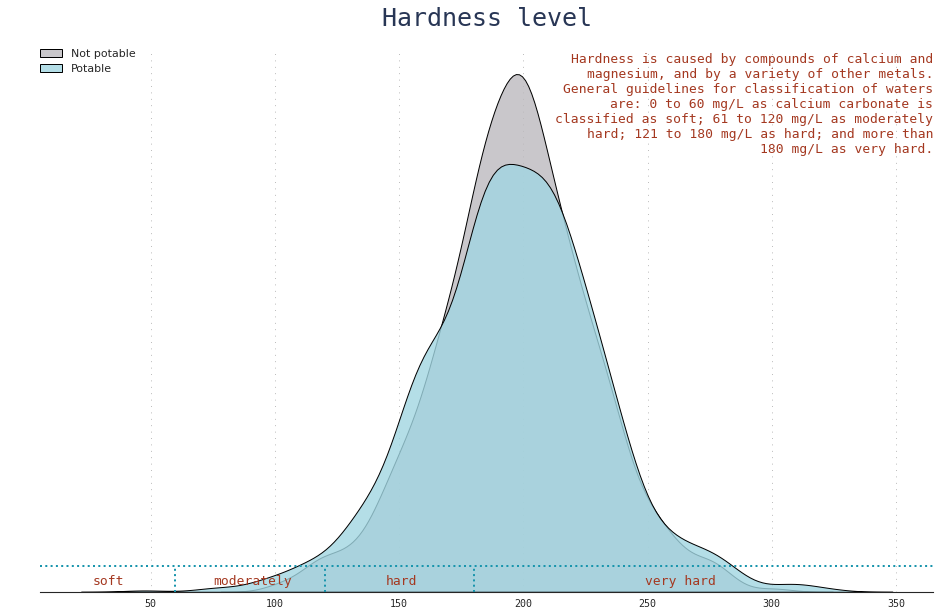

In [9]:
plt.figure(figsize = (16, 10))
sns.set_style("white")
plt.title('Hardness level', size = 25, y = 1.03, fontname = 'monospace', color = '#283655')
plt.grid(color = 'gray', linestyle = ':', axis = 'x', alpha = 0.8, zorder = 0,  dashes = (1,7))
a = sns.kdeplot(water.query("Potability == 'Not potable'")['Hardness'], color = '#bcbabe', shade = True, label = 'Not potable', alpha = 0.8, linewidth = 1, edgecolor = 'black')
sns.kdeplot(water.query("Potability == 'Potable'")['Hardness'], color = '#a1d6e2', shade = True, label = 'Potable', alpha = 0.8, linewidth = 1, edgecolor = 'black')
plt.ylabel('')
plt.xlabel('')
plt.xticks(fontname = 'monospace')
plt.yticks([])
plt.legend(['Not potable', 'Potable'], bbox_to_anchor = (0.15, 1.07), ncol = 1, borderpad = 3, frameon = False, fontsize = 11)

a.axvline(x = 60, linestyle = ':', color = '#1995ad', ymin = 0, ymax = 0.045, lw = 2)
a.axvline(x = 120, linestyle = ':', color = '#1995ad', ymin = 0, ymax = 0.045, lw = 2)
a.axvline(x = 180, linestyle = ':', color = '#1995ad', ymin = 0, ymax = 0.045, lw = 2)
a.axhline(y = 0.0007, linestyle = ':', color = '#1995ad', xmin = 0, xmax = 360, lw = 2)

for j in ['right', 'left', 'top']:
        a.spines[j].set_visible(False)
a.spines['bottom'].set_linewidth(1.1)

plt.figtext(0.17, 0.135, 'soft', fontsize = 13, fontname = 'monospace', color = '#a43820')
plt.figtext(0.275, 0.135, 'moderately', fontsize = 13, fontname = 'monospace', color = '#a43820')
plt.figtext(0.425, 0.135, 'hard', fontsize = 13, fontname = 'monospace', color = '#a43820')
plt.figtext(0.65, 0.135, 'very hard', fontsize = 13, fontname = 'monospace', color = '#a43820')
plt.figtext(0.9, 0.735, '''Hardness is caused by compounds of calcium and
magnesium, and by a variety of other metals.
General guidelines for classification of waters
are: 0 to 60 mg/L as calcium carbonate is
classified as soft; 61 to 120 mg/L as moderately
hard; 121 to 180 mg/L as hard; and more than
180 mg/L as very hard.''', fontsize = 13, fontname = 'monospace', color = '#a43820', ha = 'right')

plt.show()

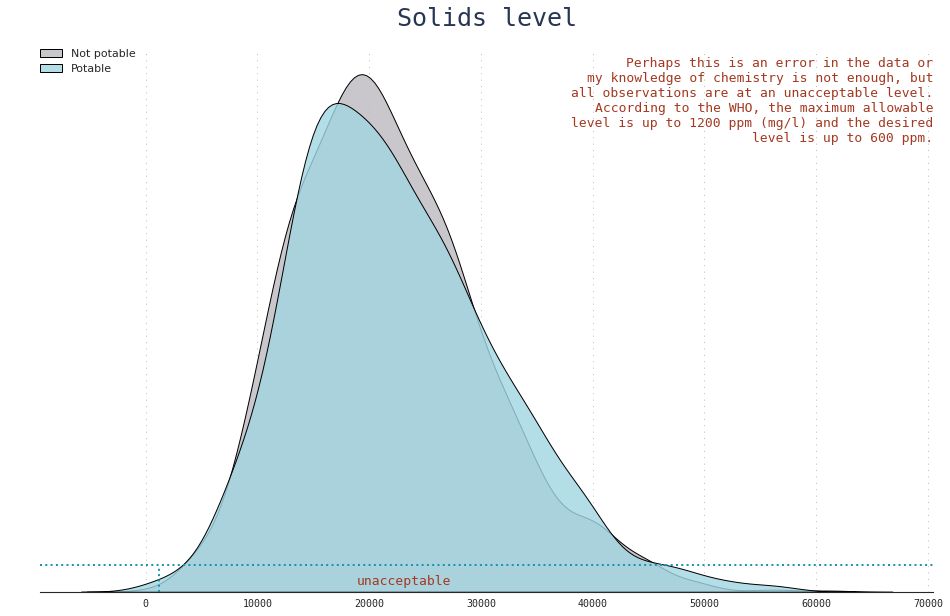

In [10]:
plt.figure(figsize = (16, 10))
sns.set_style("white")
plt.title('Solids level', size = 25, y = 1.03, fontname = 'monospace', color = '#283655')
plt.grid(color = 'gray', linestyle = ':', axis = 'x', alpha = 0.8, zorder = 0,  dashes = (1,7))
a = sns.kdeplot(water.query("Potability == 'Not potable'")['Solids'], color = '#bcbabe', shade = True, label = 'Not potable', alpha = 0.8, linewidth = 1, edgecolor = 'black')
sns.kdeplot(water.query("Potability == 'Potable'")['Solids'], color = '#a1d6e2', shade = True, label = 'Potable', alpha = 0.8, linewidth = 1, edgecolor = 'black')
plt.ylabel('')
plt.xlabel('')
plt.xticks(fontname = 'monospace')
plt.yticks([])
plt.legend(['Not potable', 'Potable'], bbox_to_anchor = (0.15, 1.07), ncol = 1, borderpad = 3, frameon = False, fontsize = 11)

a.axvline(x = 1200, linestyle = ':', color = '#1995ad', ymin = 0, ymax = 0.045, lw = 2)
a.axhline(y = 0.0000025, linestyle = ':', color = '#1995ad', xmin = 0, xmax = 1, lw = 2)

for j in ['right', 'left', 'top']:
        a.spines[j].set_visible(False)
a.spines['bottom'].set_linewidth(1.1)

plt.figtext(0.4, 0.135, 'unacceptable', fontsize = 13, fontname = 'monospace', color = '#a43820')
plt.figtext(0.9, 0.75, '''Perhaps this is an error in the data or
my knowledge of chemistry is not enough, but
all observations are at an unacceptable level.
According to the WHO, the maximum allowable
level is up to 1200 ppm (mg/l) and the desired
level is up to 600 ppm.''', fontsize = 13, fontname = 'monospace', color = '#a43820', ha = 'right')

plt.show()

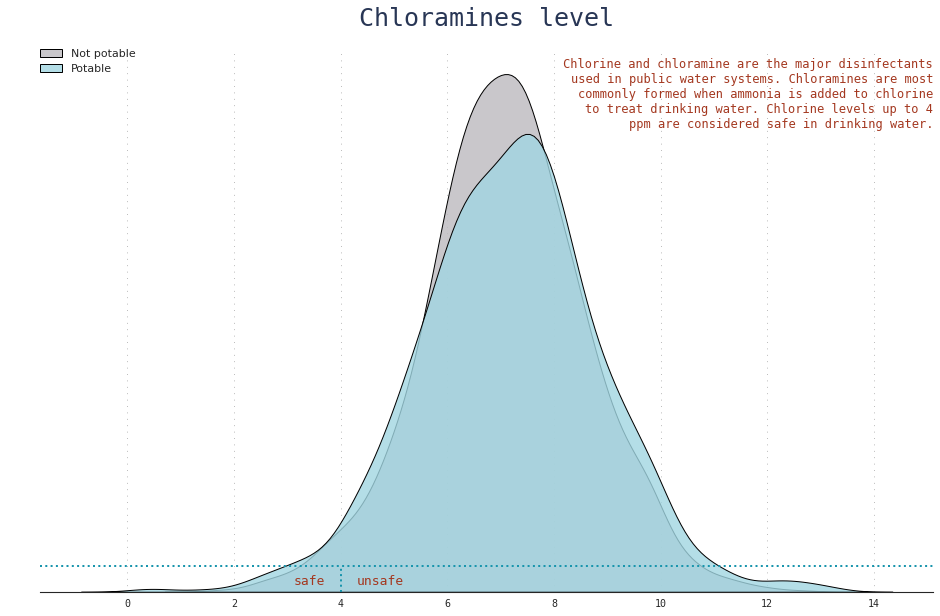

In [11]:
plt.figure(figsize = (16, 10))
sns.set_style("white")
plt.title('Chloramines level', size = 25, y = 1.03, fontname = 'monospace', color = '#283655')
plt.grid(color = 'gray', linestyle = ':', axis = 'x', alpha = 0.8, zorder = 0,  dashes = (1,7))
a = sns.kdeplot(water.query("Potability == 'Not potable'")['Chloramines'], color = '#bcbabe', shade = True, label = 'Not potable', alpha = 0.8, linewidth = 1, edgecolor = 'black')
sns.kdeplot(water.query("Potability == 'Potable'")['Chloramines'], color = '#a1d6e2', shade = True, label = 'Potable', alpha = 0.8, linewidth = 1, edgecolor = 'black')
plt.ylabel('')
plt.xlabel('')
plt.xticks(fontname = 'monospace')
plt.yticks([])
plt.legend(['Not potable', 'Potable'], bbox_to_anchor = (0.15, 1.07), ncol = 1, borderpad = 3, frameon = False, fontsize = 11)

a.axvline(x = 4, linestyle = ':', color = '#1995ad', ymin = 0, ymax = 0.045, lw = 2)
a.axhline(y = 0.014, linestyle = ':', color = '#1995ad', xmin = 0, xmax = 1, lw = 2)

for j in ['right', 'left', 'top']:
        a.spines[j].set_visible(False)
a.spines['bottom'].set_linewidth(1.1)

plt.figtext(0.345, 0.135, 'safe', fontsize = 13, fontname = 'monospace', color = '#a43820')
plt.figtext(0.4, 0.135, 'unsafe', fontsize = 13, fontname = 'monospace', color = '#a43820')
plt.figtext(0.9, 0.77, '''Chlorine and chloramine are the major disinfectants
used in public water systems. Chloramines are most
commonly formed when ammonia is added to chlorine
to treat drinking water. Chlorine levels up to 4
ppm are considered safe in drinking water.''', fontsize = 12, fontname = 'monospace', color = '#a43820', ha = 'right')

plt.show()

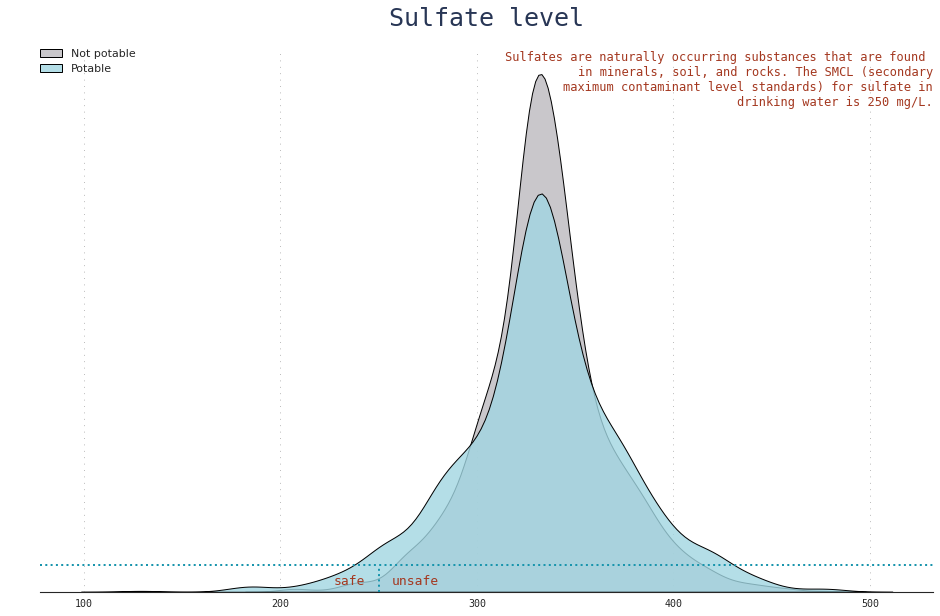

In [12]:
plt.figure(figsize = (16, 10))
sns.set_style("white")
plt.title('Sulfate level', size = 25, y = 1.03, fontname = 'monospace', color = '#283655')
plt.grid(color = 'gray', linestyle = ':', axis = 'x', alpha = 0.8, zorder = 0,  dashes = (1,7))
a = sns.kdeplot(water.query("Potability == 'Not potable'")['Sulfate'], color = '#bcbabe', shade = True, label = 'Not potable', alpha = 0.8, linewidth = 1, edgecolor = 'black')
sns.kdeplot(water.query("Potability == 'Potable'")['Sulfate'], color = '#a1d6e2', shade = True, label = 'Potable', alpha = 0.8, linewidth = 1, edgecolor = 'black')
plt.ylabel('')
plt.xlabel('')
plt.xticks(fontname = 'monospace')
plt.yticks([])
plt.legend(['Not potable', 'Potable'], bbox_to_anchor = (0.15, 1.07), ncol = 1, borderpad = 3, frameon = False, fontsize = 11)

a.axvline(x = 250, linestyle = ':', color = '#1995ad', ymin = 0, ymax = 0.045, lw = 2)
a.axhline(y = 0.0009, linestyle = ':', color = '#1995ad', xmin = 0, xmax = 1, lw = 2)

for j in ['right', 'left', 'top']:
        a.spines[j].set_visible(False)
a.spines['bottom'].set_linewidth(1.1)

plt.figtext(0.38, 0.135, 'safe', fontsize = 13, fontname = 'monospace', color = '#a43820')
plt.figtext(0.43, 0.135, 'unsafe', fontsize = 13, fontname = 'monospace', color = '#a43820')
plt.figtext(0.9, 0.8, '''Sulfates are naturally occurring substances that are found 
in minerals, soil, and rocks. The SMCL (secondary
maximum contaminant level standards) for sulfate in
drinking water is 250 mg/L.''', fontsize = 12, fontname = 'monospace', color = '#a43820', ha = 'right')

plt.show()

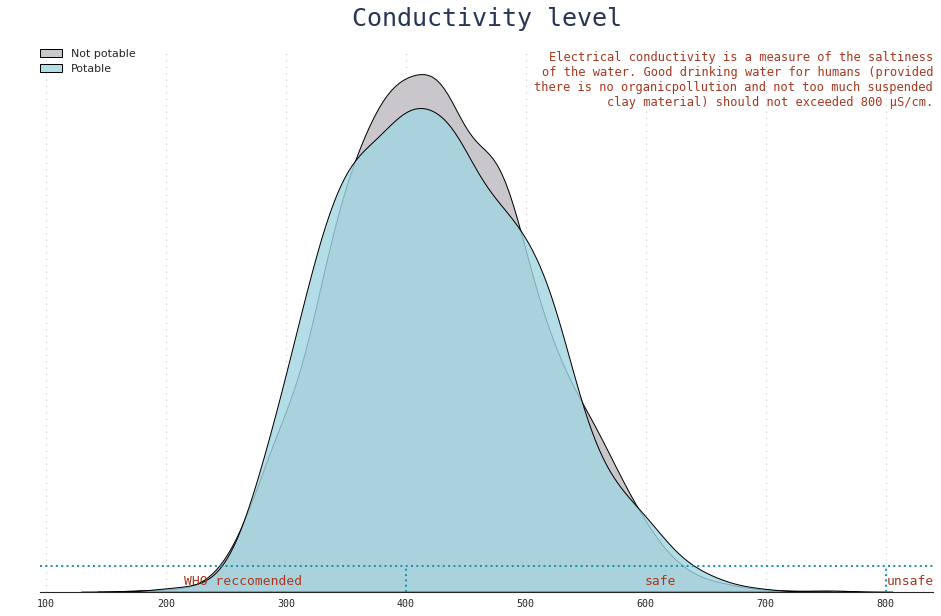

In [13]:
plt.figure(figsize = (16, 10))
sns.set_style("white")
plt.title('Conductivity level', size = 25, y = 1.03, fontname = 'monospace', color = '#283655')
plt.grid(color = 'gray', linestyle = ':', axis = 'x', alpha = 0.8, zorder = 0,  dashes = (1,7))
a = sns.kdeplot(water.query("Potability == 'Not potable'")['Conductivity'], color = '#bcbabe', shade = True, label = 'Not potable', alpha = 0.8, linewidth = 1, edgecolor = 'black')
sns.kdeplot(water.query("Potability == 'Potable'")['Conductivity'], color = '#a1d6e2', shade = True, label = 'Potable', alpha = 0.8, linewidth = 1, edgecolor = 'black')
plt.ylabel('')
plt.xlabel('')
plt.xticks(fontname = 'monospace')
plt.yticks([])
plt.legend(['Not potable', 'Potable'], bbox_to_anchor = (0.15, 1.07), ncol = 1, borderpad = 3, frameon = False, fontsize = 11)

a.axvline(x = 400, linestyle = ':', color = '#1995ad', ymin = 0, ymax = 0.045, lw = 2)
a.axvline(x = 800, linestyle = ':', color = '#1995ad', ymin = 0, ymax = 0.045, lw = 2)
a.axhline(y = 0.00023, linestyle = ':', color = '#1995ad', xmin = 0, xmax = 1, lw = 2)

for j in ['right', 'left', 'top']:
        a.spines[j].set_visible(False)
a.spines['bottom'].set_linewidth(1.1)

plt.figtext(0.25, 0.135, 'WHO reccomended', fontsize = 13, fontname = 'monospace', color = '#a43820')
plt.figtext(0.65, 0.135, 'safe', fontsize = 13, fontname = 'monospace', color = '#a43820')
plt.figtext(0.86, 0.135, 'unsafe', fontsize = 13, fontname = 'monospace', color = '#a43820')
plt.figtext(0.9, 0.8, '''Electrical conductivity is a measure of the saltiness
of the water. Good drinking water for humans (provided
there is no organicpollution and not too much suspended
clay material) should not exceeded 800 μS/cm.''', fontsize = 12, fontname = 'monospace', color = '#a43820', ha = 'right')


plt.show()

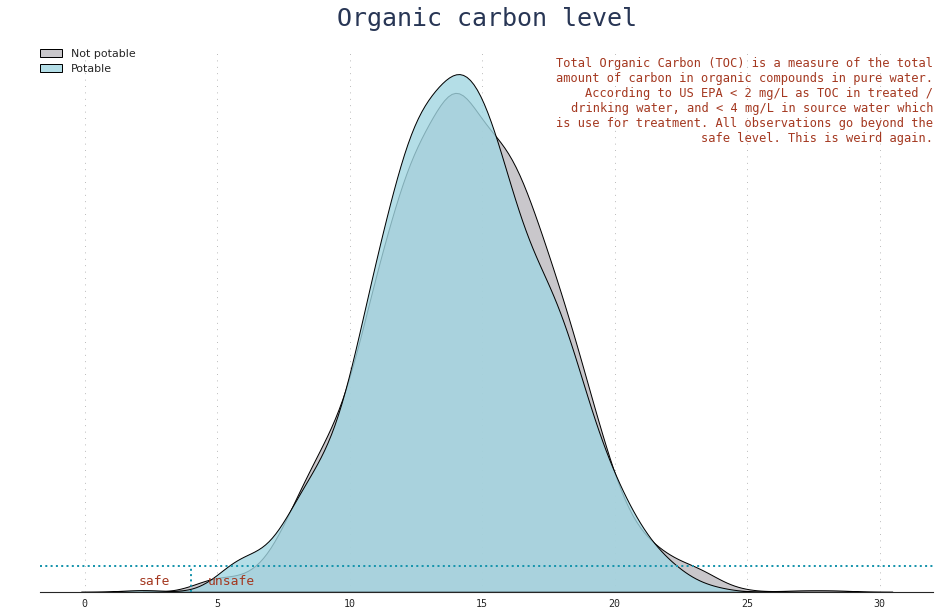

In [14]:
plt.figure(figsize = (16, 10))
sns.set_style("white")
plt.title('Organic carbon level', size = 25, y = 1.03, fontname = 'monospace', color = '#283655')
plt.grid(color = 'gray', linestyle = ':', axis = 'x', alpha = 0.8, zorder = 0,  dashes = (1,7))
a = sns.kdeplot(water.query("Potability == 'Not potable'")['Organic_carbon'], color = '#bcbabe', shade = True, label = 'Not potable', alpha = 0.8, linewidth = 1, edgecolor = 'black')
sns.kdeplot(water.query("Potability == 'Potable'")['Organic_carbon'], color = '#a1d6e2', shade = True, label = 'Potable', alpha = 0.8, linewidth = 1, edgecolor = 'black')
plt.ylabel('')
plt.xlabel('')
plt.xticks(fontname = 'monospace')
plt.yticks([])
plt.legend(['Not potable', 'Potable'], bbox_to_anchor = (0.15, 1.07), ncol = 1, borderpad = 3, frameon = False, fontsize = 11)

a.axvline(x = 4, linestyle = ':', color = '#1995ad', ymin = 0, ymax = 0.045, lw = 2)
a.axhline(y = 0.006, linestyle = ':', color = '#1995ad', xmin = 0, xmax = 1, lw = 2)

for j in ['right', 'left', 'top']:
        a.spines[j].set_visible(False)
a.spines['bottom'].set_linewidth(1.1)

plt.figtext(0.21, 0.135, 'safe', fontsize = 13, fontname = 'monospace', color = '#a43820')
plt.figtext(0.27, 0.135, 'unsafe', fontsize = 13, fontname = 'monospace', color = '#a43820')
plt.figtext(0.9, 0.75, '''Total Organic Carbon (TOC) is a measure of the total
amount of carbon in organic compounds in pure water.
According to US EPA < 2 mg/L as TOC in treated /
drinking water, and < 4 mg/L in source water which
is use for treatment. All observations go beyond the
safe level. This is weird again.''', fontsize = 12, fontname = 'monospace', color = '#a43820', ha = 'right')


plt.show()

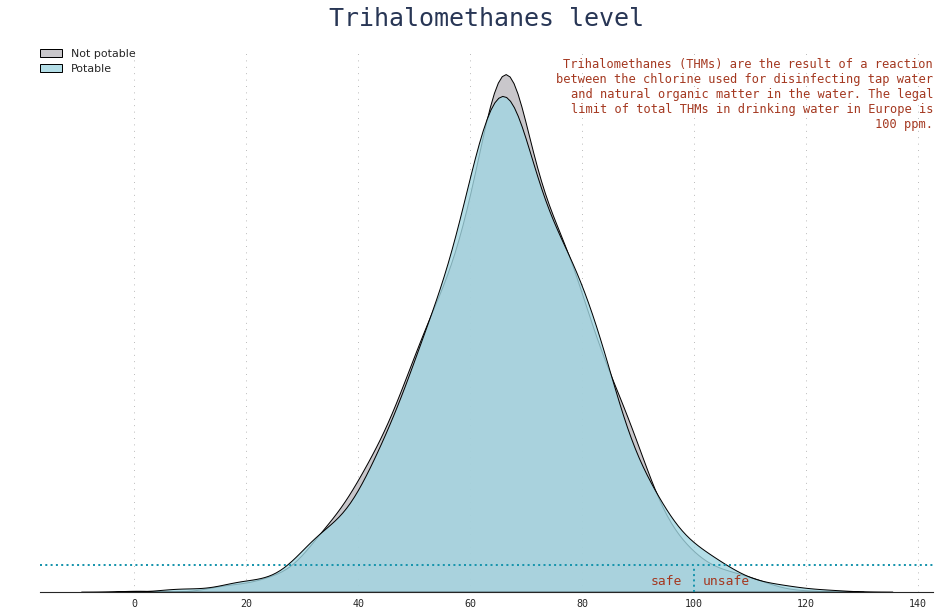

In [15]:
plt.figure(figsize = (16, 10))
sns.set_style("white")
plt.title('Trihalomethanes level', size = 25, y = 1.03, fontname = 'monospace', color = '#283655')
plt.grid(color = 'gray', linestyle = ':', axis = 'x', alpha = 0.8, zorder = 0,  dashes = (1,7))
a = sns.kdeplot(water.query("Potability == 'Not potable'")['Trihalomethanes'], color = '#bcbabe', shade = True, label = 'Not potable', alpha = 0.8, linewidth = 1, edgecolor = 'black')
sns.kdeplot(water.query("Potability == 'Potable'")['Trihalomethanes'], color = '#a1d6e2', shade = True, label = 'Potable', alpha = 0.8, linewidth = 1, edgecolor = 'black')
plt.ylabel('')
plt.xlabel('')
plt.xticks(fontname = 'monospace')
plt.yticks([])
plt.legend(['Not potable', 'Potable'], bbox_to_anchor = (0.15, 1.07), ncol = 1, borderpad = 3, frameon = False, fontsize = 11)

a.axvline(x = 100, linestyle = ':', color = '#1995ad', ymin = 0, ymax = 0.045, lw = 2)
a.axhline(y = 0.0015, linestyle = ':', color = '#1995ad', xmin = 0, xmax = 1, lw = 2)

for j in ['right', 'left', 'top']:
        a.spines[j].set_visible(False)
a.spines['bottom'].set_linewidth(1.1)

plt.figtext(0.655, 0.135, 'safe', fontsize = 13, fontname = 'monospace', color = '#a43820')
plt.figtext(0.7, 0.135, 'unsafe', fontsize = 13, fontname = 'monospace', color = '#a43820')
plt.figtext(0.9, 0.77, '''Trihalomethanes (THMs) are the result of a reaction
between the chlorine used for disinfecting tap water
and natural organic matter in the water. The legal
limit of total THMs in drinking water in Europe is
100 ppm.''', fontsize = 12, fontname = 'monospace', color = '#a43820', ha = 'right')

plt.show()

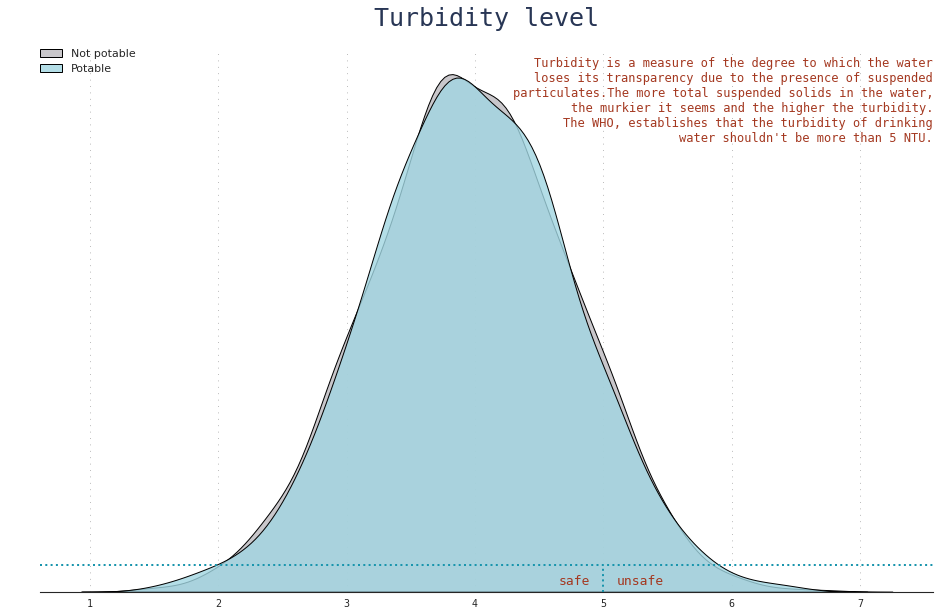

In [16]:
plt.figure(figsize = (16, 10))
sns.set_style("white")
plt.title('Turbidity level', size = 25, y = 1.03, fontname = 'monospace', color = '#283655')
plt.grid(color = 'gray', linestyle = ':', axis = 'x', alpha = 0.8, zorder = 0,  dashes = (1,7))
a = sns.kdeplot(water.query("Potability == 'Not potable'")['Turbidity'], color = '#bcbabe', shade = True, label = 'Not potable', alpha = 0.8, linewidth = 1, edgecolor = 'black')
sns.kdeplot(water.query("Potability == 'Potable'")['Turbidity'], color = '#a1d6e2', shade = True, label = 'Potable', alpha = 0.8, linewidth = 1, edgecolor = 'black')
plt.ylabel('')
plt.xlabel('')
plt.xticks(fontname = 'monospace')
plt.yticks([])
plt.legend(['Not potable', 'Potable'], bbox_to_anchor = (0.15, 1.07), ncol = 1, borderpad = 3, frameon = False, fontsize = 11)

a.axvline(x = 5, linestyle = ':', color = '#1995ad', ymin = 0, ymax = 0.045, lw = 2)
a.axhline(y = 0.026, linestyle = ':', color = '#1995ad', xmin = 0, xmax = 1, lw = 2)

for j in ['right', 'left', 'top']:
        a.spines[j].set_visible(False)
a.spines['bottom'].set_linewidth(1.1)

plt.figtext(0.575, 0.135, 'safe', fontsize = 13, fontname = 'monospace', color = '#a43820')
plt.figtext(0.625, 0.135, 'unsafe', fontsize = 13, fontname = 'monospace', color = '#a43820')
plt.figtext(0.9, 0.75, '''Turbidity is a measure of the degree to which the water
loses its transparency due to the presence of suspended
particulates.The more total suspended solids in the water,
the murkier it seems and the higher the turbidity.
The WHO, establishes that the turbidity of drinking
water shouldn't be more than 5 NTU.''', fontsize = 12, fontname = 'monospace', color = '#a43820', ha = 'right')


plt.show()

**Let's look at the correlations. Maybe this will show the dependence of the potability of water.**

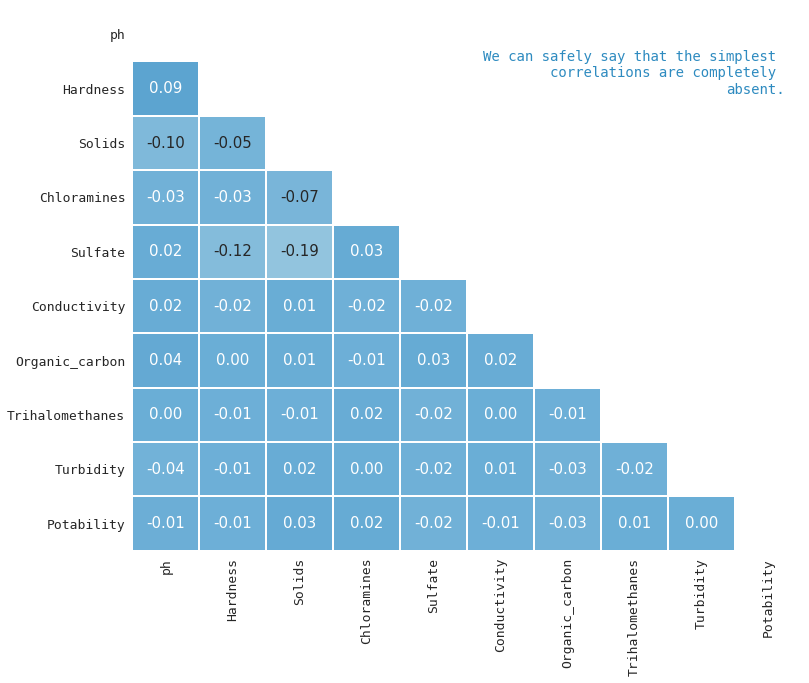

In [17]:
repot = {'Not potable': 0, 'Potable': 1}
water['Potability'] = water['Potability'].map(repot)

matrix = np.triu(water.corr())
plt.figure(figsize=(12, 10))
sns.heatmap(water.corr(), annot = True, cmap = 'Blues', fmt=".2f", mask = matrix, vmin = -1, vmax = 1, linewidths = 0.1, linecolor = 'white', cbar = False, annot_kws = {'fontsize': 15})
plt.xticks(size = 13, fontname = 'monospace')
plt.yticks(size = 13, fontname = 'monospace')
plt.figtext(0.88, 0.76, '''We can safely say that the simplest 
correlations are completely 
absent.''', fontsize = 14, fontname = 'monospace', color = '#2E8BC0', ha = 'right')
plt.show()

water['Potability'] = water['Potability'].map(repotability)

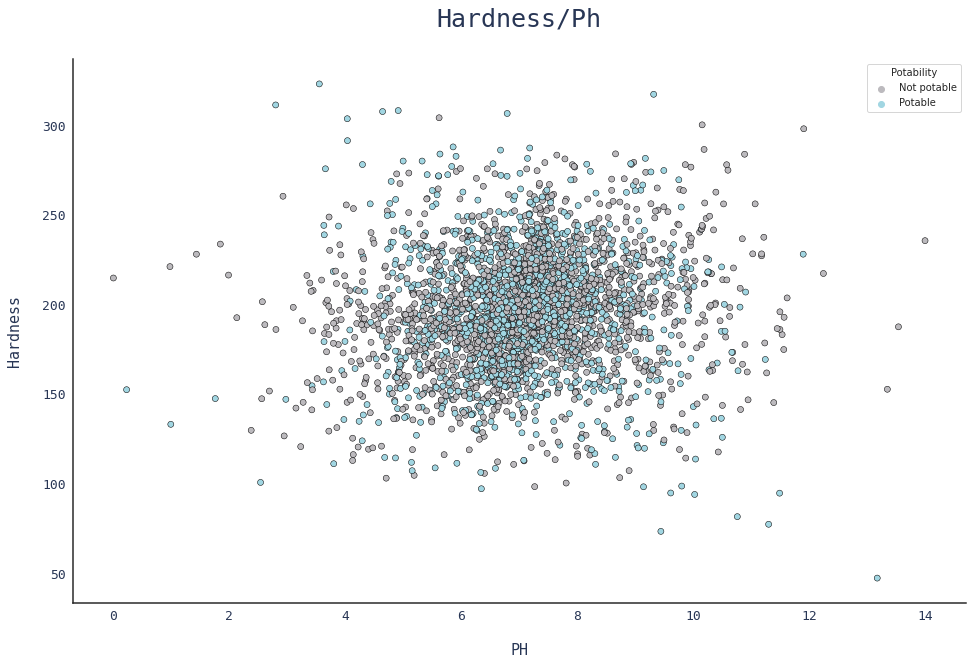

In [18]:
plt.figure(figsize = (16, 10))
sns.set_style("white")
plt.title('Hardness/Ph', size = 25, y = 1.05, fontname = 'monospace', color = '#283655')
a = sns.scatterplot(x = "ph", y = "Hardness", hue = "Potability", palette = ['#bcbabe', '#a1d6e2'], sizes = (1, 8), linewidth = 0.5, data = water, edgecolor = "black")
plt.xticks(fontname = 'monospace', size = 13, color = '#283655')
plt.yticks(fontname = 'monospace', size = 13, color = '#283655')
plt.ylabel('Hardness', labelpad = 20, fontname = 'monospace', fontsize = 15, color = '#283655')
plt.xlabel('PH', labelpad = 20, fontname = 'monospace', fontsize = 15, color = '#283655')

for j in ['right', 'top']:
        a.spines[j].set_visible(False)
for j in ['bottom', 'left']:
    a.spines[j].set_linewidth(1.5)
    

plt.show()

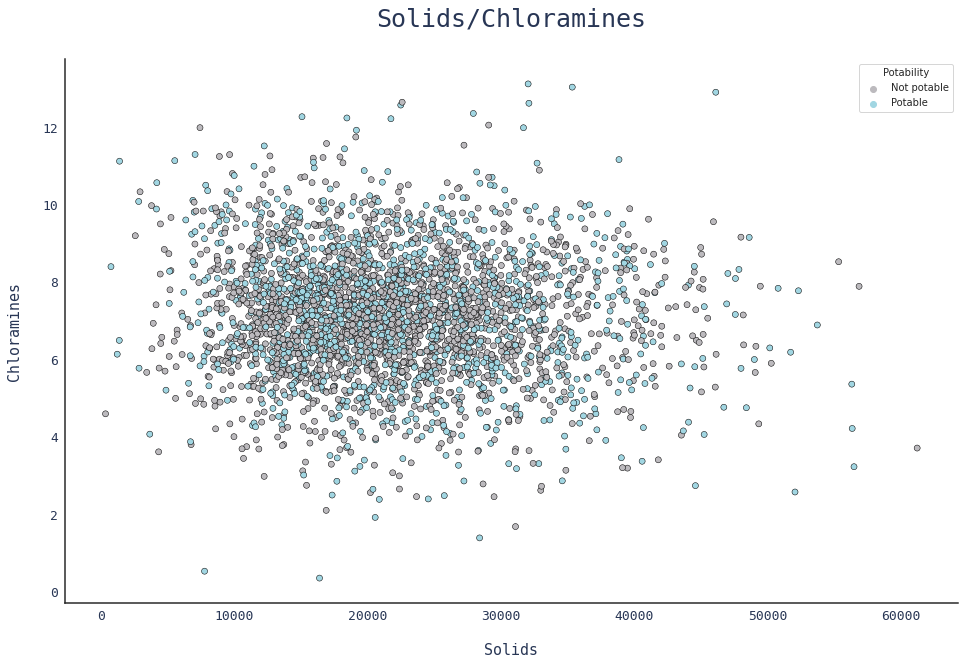

In [19]:
plt.figure(figsize = (16, 10))
sns.set_style("white")
plt.title('Solids/Chloramines', size = 25, y = 1.05, fontname = 'monospace', color = '#283655')
a = sns.scatterplot(x = "Solids", y = "Chloramines", hue = "Potability", palette = ['#bcbabe', '#a1d6e2'], sizes = (1, 8), linewidth = 0.5, data = water, edgecolor = "black")
plt.xticks(fontname = 'monospace', size = 13, color = '#283655')
plt.yticks(fontname = 'monospace', size = 13, color = '#283655')
plt.ylabel('Chloramines', labelpad = 20, fontname = 'monospace', fontsize = 15, color = '#283655')
plt.xlabel('Solids', labelpad = 20, fontname = 'monospace', fontsize = 15, color = '#283655')

for j in ['right', 'top']:
        a.spines[j].set_visible(False)
for j in ['bottom', 'left']:
    a.spines[j].set_linewidth(1.5)
    

plt.show()

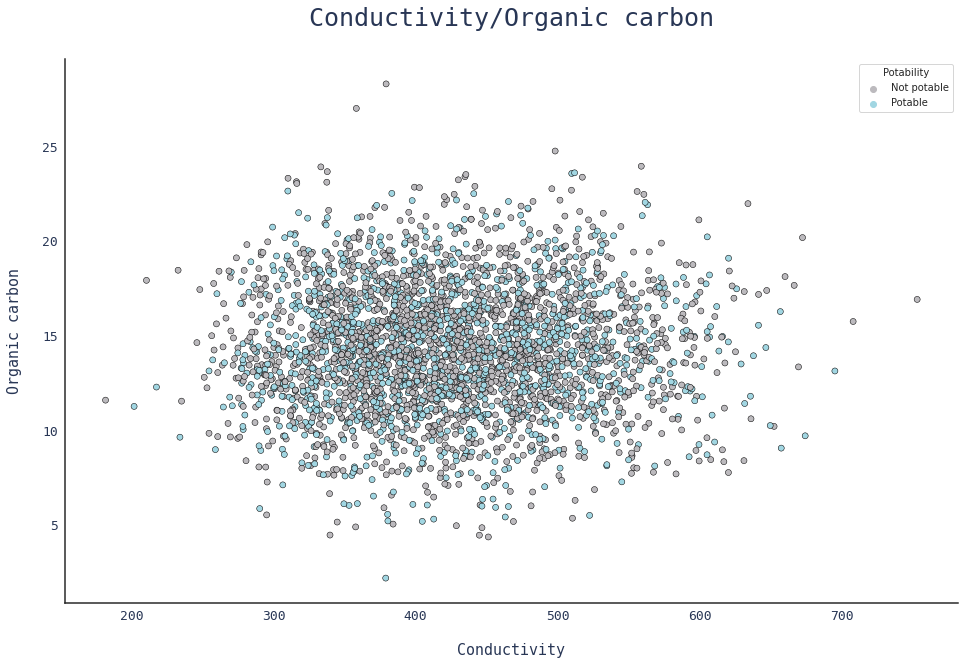

In [20]:
plt.figure(figsize = (16, 10))
sns.set_style("white")
plt.title('Conductivity/Organic carbon', size = 25, y = 1.05, fontname = 'monospace', color = '#283655')
a = sns.scatterplot(x = "Conductivity", y = "Organic_carbon", hue = "Potability", palette = ['#bcbabe', '#a1d6e2'], sizes = (1, 8), linewidth = 0.5, data = water, edgecolor = "black")
plt.xticks(fontname = 'monospace', size = 13, color = '#283655')
plt.yticks(fontname = 'monospace', size = 13, color = '#283655')
plt.ylabel('Organic carbon', labelpad = 20, fontname = 'monospace', fontsize = 15, color = '#283655')
plt.xlabel('Conductivity', labelpad = 20, fontname = 'monospace', fontsize = 15, color = '#283655')

for j in ['right', 'top']:
        a.spines[j].set_visible(False)
for j in ['bottom', 'left']:
    a.spines[j].set_linewidth(1.5)
    

plt.show()

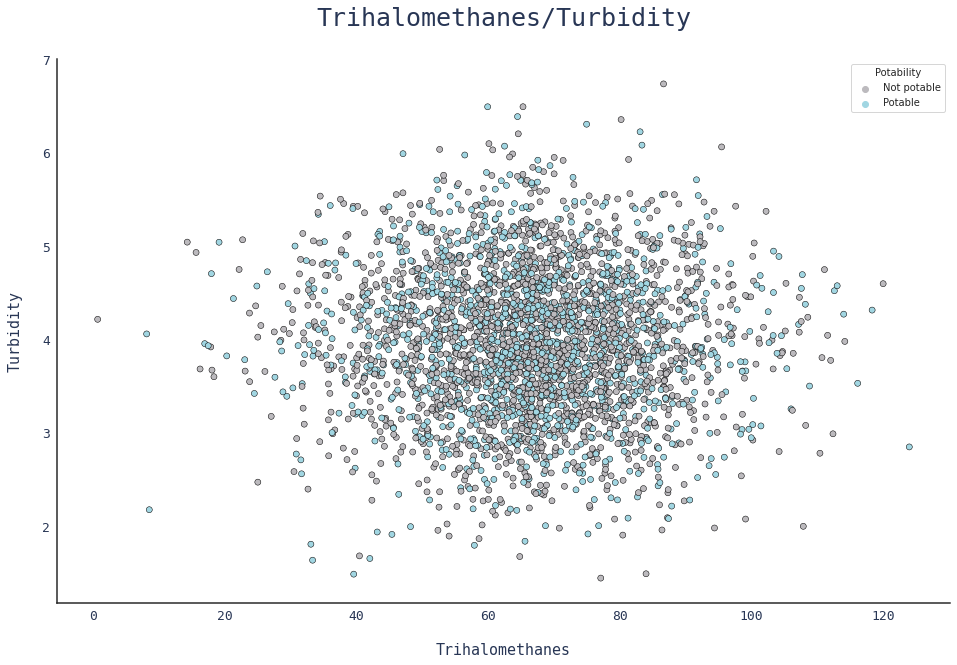

In [21]:
plt.figure(figsize = (16, 10))
sns.set_style("white")
plt.title('Trihalomethanes/Turbidity', size = 25, y = 1.05, fontname = 'monospace', color = '#283655')
a = sns.scatterplot(x = "Trihalomethanes", y = "Turbidity", hue = "Potability", palette = ['#bcbabe', '#a1d6e2'], sizes = (1, 8), linewidth = 0.5, data = water, edgecolor = "black")
plt.xticks(fontname = 'monospace', size = 13, color = '#283655')
plt.yticks(fontname = 'monospace', size = 13, color = '#283655')
plt.ylabel('Turbidity', labelpad = 20, fontname = 'monospace', fontsize = 15, color = '#283655')
plt.xlabel('Trihalomethanes', labelpad = 20, fontname = 'monospace', fontsize = 15, color = '#283655')

for j in ['right', 'top']:
        a.spines[j].set_visible(False)
for j in ['bottom', 'left']:
    a.spines[j].set_linewidth(1.5)
    

plt.show()

**Well, let's try to go out in 3D. So far, all the data seems to be one random.**

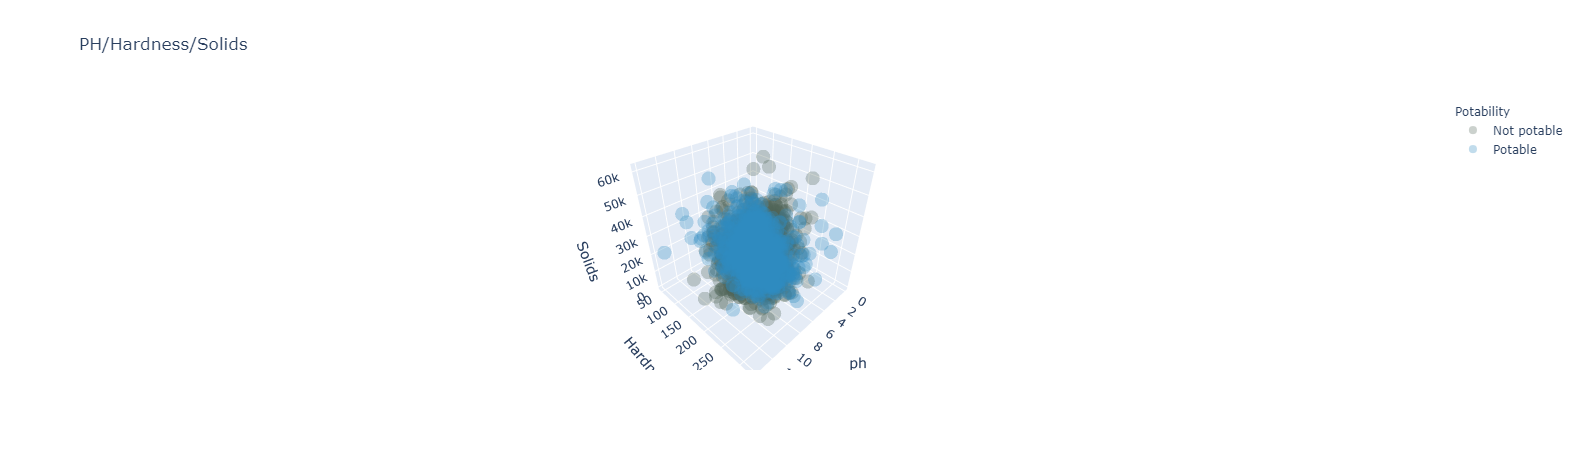

In [22]:
fig = px.scatter_3d(water, x = 'ph', y = 'Hardness', z = 'Solids', 
                    color = 'Potability', opacity = 0.3, title = 'PH/Hardness/Solids',
                    color_discrete_sequence = ['#4f6457', '#2E8BC0'])
fig.show()

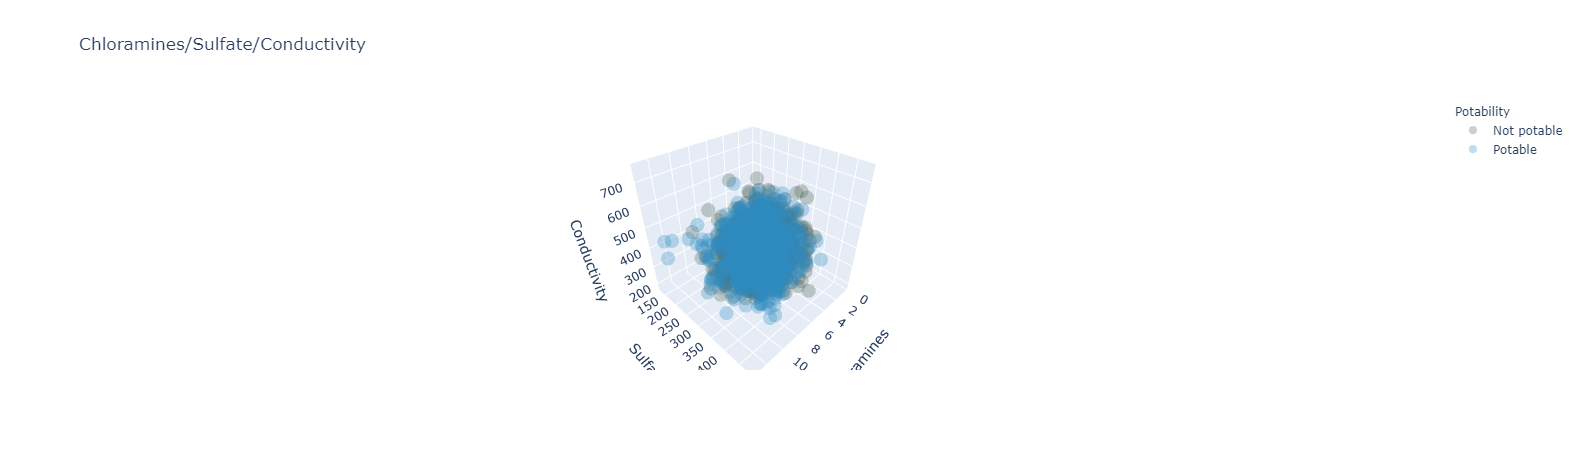

In [23]:
fig = px.scatter_3d(water, x = 'Chloramines', y = 'Sulfate', z = 'Conductivity', 
                    color = 'Potability', opacity = 0.3, title = 'Chloramines/Sulfate/Conductivity',
                   color_discrete_sequence = ['#4f6457', '#2E8BC0'])
fig.show()

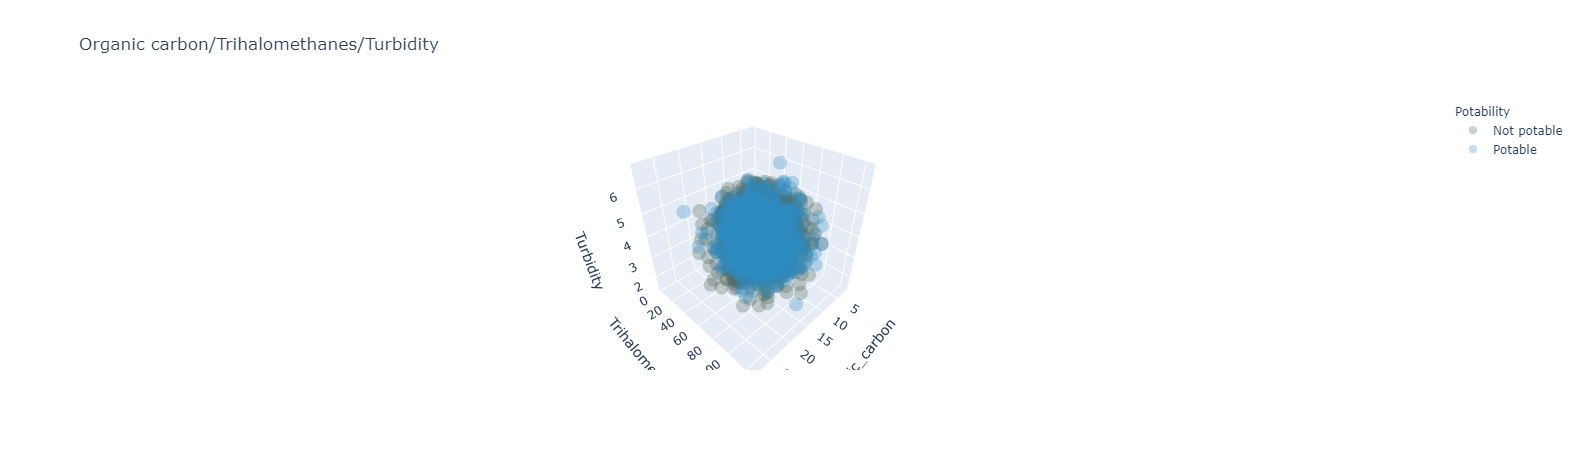

In [24]:
fig = px.scatter_3d(water, x = 'Organic_carbon', y = 'Trihalomethanes', z = 'Turbidity', 
                    color = 'Potability', opacity = 0.3, title = 'Organic carbon/Trihalomethanes/Turbidity',
                    color_discrete_sequence = ['#4f6457', '#2E8BC0'])
fig.show()

**It may seem so, but based on the 3D models, it is clear that the concentration of potability water is located in the middle of the clouds (especially if you bring it a little closer).**

P.S. It's not because of the brightness of the colors (checked) + observations with potable are in the minority.

# Conclusions of the EDA

**I have a lot of questions to the author of this dataset and the original source, where the data was taken from.**

1. In all the columns the distribution of potable and not potable water is almost completely the same - this is very strange.

2. All observations for many indicators (solids, chloramines, sulfates and organic carbon) are at an unsafe level. How can potable water have increased values for these indicators? Based on the most common logic, chemistry and medicine, all observations should be attributed to not potable water. The only reasonable explanation that I could understand is if the increased indicators in one category would make the normal indicators in another category, that is, they would level out, but I strongly doubt that this is the case.

3. This data does not look like real data at all.

4. I have no idea how the models will be trained from this data and how much multidimensional space they will have to go into to find correlations. But it will be interesting.

# Preprocessing for modeling

In [25]:
water['Potability'] = water['Potability'].map(repot)

X = water.drop(['Potability'], axis = 1)
y = water['Potability']

num_cols = X.select_dtypes(include = ['float64']).columns.to_list()

sc = StandardScaler()
X[num_cols] = sc.fit_transform(X[num_cols])

X.head()

ph  Hardness    Solids  Chloramines   Sulfate  Conductivity  \
0 -0.013296  0.259195 -0.139471     0.112415  0.938538      1.708954   
1 -2.271926 -2.036414 -0.385987    -0.307694  0.915301      2.062575   
2  0.690084  0.847665 -0.240047     1.360594 -0.264010     -0.094032   
3  0.837164  0.547651  0.000493     0.592008  0.622511     -0.778830   
4  1.361209 -0.464429 -0.460249    -0.363698 -0.647826     -0.343939   

   Organic_carbon  Trihalomethanes  Turbidity  
0       -1.180651         1.305188  -1.286298  
1        0.270597        -0.638509   0.684218  
2        0.781117         0.001173  -1.167365  
3        1.255134         2.151507   0.848412  
4       -0.824357        -2.180889   0.138786

The data is a little unbalanced, so I use SMOTE for the ratio 50/50 of the target variable.

In [26]:
from imblearn.over_sampling import SMOTE

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 228)

smote = SMOTE()

X_train_balanced, Y_train_balanced = smote.fit_resample(X_train, y_train)

In [27]:
results = pd.DataFrame(columns = ['DTC', 'RF', 'LGBM', 'XGB'], index = range(4))

# Decision Tree Classifier

**The first thing I want to check is Decision tree classifier. It is very interesting to look at it's results and the ways of this tree to get rid of chaos. Here I will use Optuna with 50 trials and cross-validation with 10 folds to find best parameters.**

In [31]:
def objective(trial, data = X, target = y):

    params = {
        'max_depth': trial.suggest_int('max_depth', 2, 8),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 30),
        'random_state': 228
    }
    
    model = DecisionTreeClassifier(**params)
    return cross_val_score(model, X_train_balanced, Y_train_balanced, cv = 10, scoring = 'accuracy').mean()

study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 50)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Best value:', study.best_value)

[I 2021-07-13 14:03:02,695] A new study created in memory with name: no-name-6bf7aba8-89da-4bc4-a98c-11f165ac7e50
[I 2021-07-13 14:03:02,840] Trial 0 finished with value: 0.5445154334544584 and parameters: {'max_depth': 2, 'min_samples_leaf': 28, 'min_samples_split': 5}. Best is trial 0 with value: 0.5445154334544584.
[I 2021-07-13 14:03:03,037] Trial 1 finished with value: 0.5707073833007227 and parameters: {'max_depth': 4, 'min_samples_leaf': 10, 'min_samples_split': 14}. Best is trial 1 with value: 0.5707073833007227.
[I 2021-07-13 14:03:03,240] Trial 2 finished with value: 0.571022840713972 and parameters: {'max_depth': 4, 'min_samples_leaf': 5, 'min_samples_split': 2}. Best is trial 2 with value: 0.571022840713972.
[I 2021-07-13 14:03:03,414] Trial 3 finished with value: 0.5760811404384458 and parameters: {'max_depth': 3, 'min_samples_leaf': 6, 'min_samples_split': 27}. Best is trial 3 with value: 0.5760811404384458.
[I 2021-07-13 14:03:03,645] Trial 4 finished with value: 0.57514

Number of finished trials: 50
Best trial: {'max_depth': 8, 'min_samples_leaf': 9, 'min_samples_split': 9}
Best value: 0.6146078744559358


              precision    recall  f1-score   support

           0       0.74      0.55      0.63       414
           1       0.46      0.67      0.55       242

    accuracy                           0.59       656
   macro avg       0.60      0.61      0.59       656
weighted avg       0.64      0.59      0.60       656

ROC AUC score: 0.639

-----------------------------------------------------

Cross-validation scores with 10 folds:

ROC AUC: 0.657
precision: 0.63
recall: 0.59
f1: 0.6


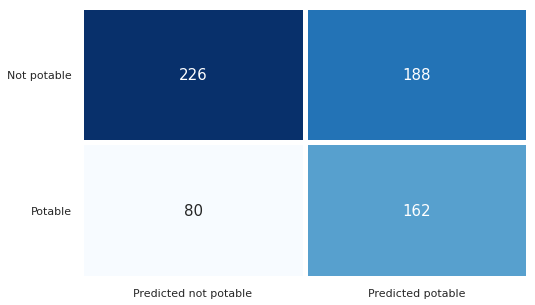

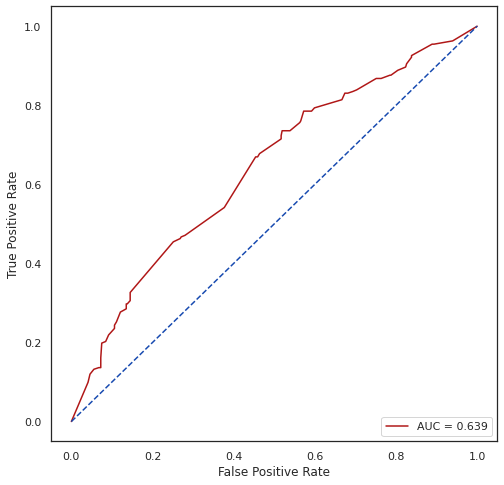

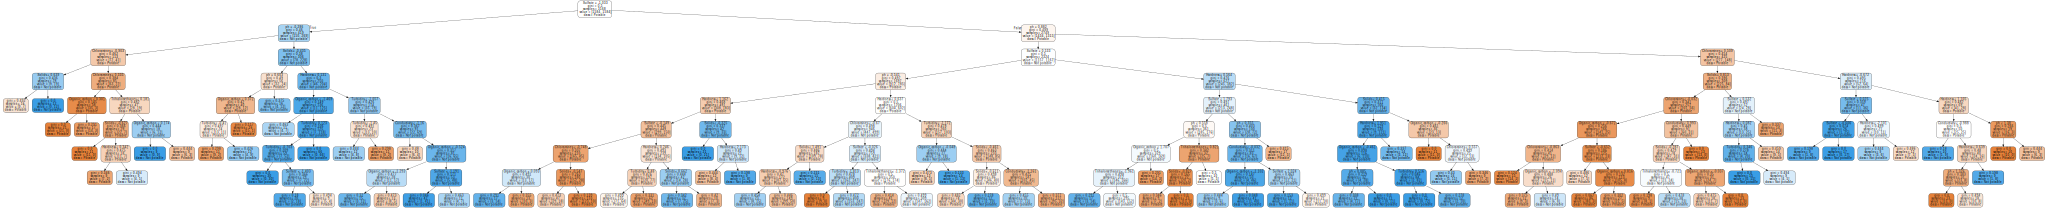

In [32]:
params = study.best_params
params['random_state'] = 228
dtc = DecisionTreeClassifier(**params)
dtc.fit(X_train_balanced, Y_train_balanced)
y_pred = dtc.predict(X_val)
y_prob = dtc.predict_proba(X_val)[:,1]

# Metrics
results.iloc[0, 0] = round(cross_val_score(dtc, X_train_balanced, Y_train_balanced, cv = 10, scoring = 'precision').mean(), 2)
results.iloc[1, 0] = round(cross_val_score(dtc, X_train_balanced, Y_train_balanced, cv = 10, scoring = 'recall').mean(), 2)
results.iloc[2, 0] = round(cross_val_score(dtc, X_train_balanced, Y_train_balanced, cv = 10, scoring = 'f1').mean(), 2)
results.iloc[3, 0] = round(cross_val_score(dtc, X_train_balanced, Y_train_balanced, cv = 10, scoring = 'roc_auc').mean(), 3)
dtc_cm = confusion_matrix(y_val, y_pred)

print(classification_report(y_val, y_pred))
print(f'ROC AUC score: {round(roc_auc_score(y_val, y_prob), 3)}')
print('')
print('-----------------------------------------------------')
print('')
print('Cross-validation scores with 10 folds:')
print('')
print(f"ROC AUC: {results.iloc[3, 0]}")
print(f"precision: {results.iloc[0, 0]}")
print(f"recall: {results.iloc[1, 0]}")
print(f"f1: {results.iloc[2, 0]}")

# Visualize confusion matrix
plt.figure(figsize = (8, 5))
sns.heatmap(dtc_cm, cmap = 'Blues', annot = True, fmt = 'd', linewidths = 5, cbar = False, annot_kws = {'fontsize': 15}, 
            yticklabels = ['Not potable', 'Potable'], xticklabels = ['Predicted not potable', 'Predicted potable'])
plt.yticks(rotation = 0)
plt.show()

# Roc curve
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_val, y_prob)
roc_auc = auc(false_positive_rate, true_positive_rate)

sns.set_theme(style = 'white')
plt.figure(figsize = (8, 8))
plt.plot(false_positive_rate,true_positive_rate, color = '#b01717', label = 'AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], linestyle = '--', color = '#174ab0')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Decision tree
import graphviz 
from sklearn import tree

Y_train_balanced = Y_train_balanced.map(repotability)

dtc = DecisionTreeClassifier(**params)
dtc.fit(X_train_balanced, Y_train_balanced)

dot_data = tree.export_graphviz(dtc, out_file=None, 
                              feature_names=X_train_balanced.columns,  
                              class_names=Y_train_balanced,  
                              filled=True, rounded=True,  
                              special_characters=True)

graph = graphviz.Source(dot_data) 
graph 

In [33]:
Y_train_balanced = Y_train_balanced.map(repot)

**Honestly, I expected a worse result for one tree.**

**By the way, an interesting note is that if you do not make the same ratio of classes in the target variable, then the visualized tree will lead to one class, in our case, to not potable water. This is exactly the reason why it is better to maintain an even balance. The same error is prone to logistic regression.**

# Random Forest

**Here I will also use Optuna with 50 trials and cross-validation with 5 folds to find best parameters.**

In [36]:
def objective(trial, data = X, target = y):

    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'max_depth': trial.suggest_int('max_depth', 2, 8),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 30),
        'random_state': 228
    }
    
    model = RandomForestClassifier(**params)
    
    return cross_val_score(model, X_train_balanced, Y_train_balanced, cv = 5, scoring = 'accuracy').mean()

study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 50)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Best value:', study.best_value)

[I 2021-07-13 14:33:07,280] A new study created in memory with name: no-name-77c1f4e7-89ec-4589-a443-3a54949926cd
[I 2021-07-13 14:33:16,387] Trial 0 finished with value: 0.5580865240380543 and parameters: {'n_estimators': 543, 'max_depth': 2, 'min_samples_leaf': 21, 'min_samples_split': 10}. Best is trial 0 with value: 0.5580865240380543.
[I 2021-07-13 14:33:27,457] Trial 1 finished with value: 0.6003877185900599 and parameters: {'n_estimators': 492, 'max_depth': 4, 'min_samples_leaf': 8, 'min_samples_split': 17}. Best is trial 1 with value: 0.6003877185900599.
[I 2021-07-13 14:33:38,648] Trial 2 finished with value: 0.5861861547585231 and parameters: {'n_estimators': 571, 'max_depth': 3, 'min_samples_leaf': 13, 'min_samples_split': 19}. Best is trial 1 with value: 0.6003877185900599.
[I 2021-07-13 14:33:59,870] Trial 3 finished with value: 0.6509002745924718 and parameters: {'n_estimators': 707, 'max_depth': 7, 'min_samples_leaf': 6, 'min_samples_split': 16}. Best is trial 3 with val

Number of finished trials: 50
Best trial: {'n_estimators': 491, 'max_depth': 8, 'min_samples_leaf': 2, 'min_samples_split': 15}
Best value: 0.6707905372743084


              precision    recall  f1-score   support

           0       0.70      0.70      0.70       414
           1       0.49      0.50      0.49       242

    accuracy                           0.63       656
   macro avg       0.60      0.60      0.60       656
weighted avg       0.63      0.63      0.63       656

ROC AUC score: 0.663

-----------------------------------------------------

Cross-validation scores with 10 folds:

ROC AUC: 0.741
precision: 0.68
recall: 0.65
f1: 0.66


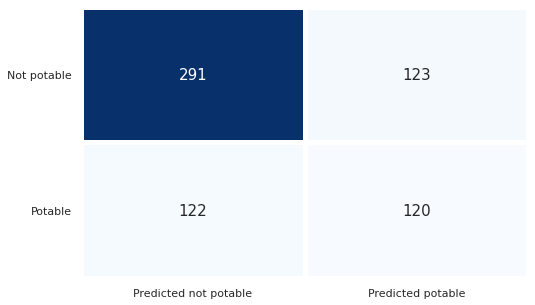

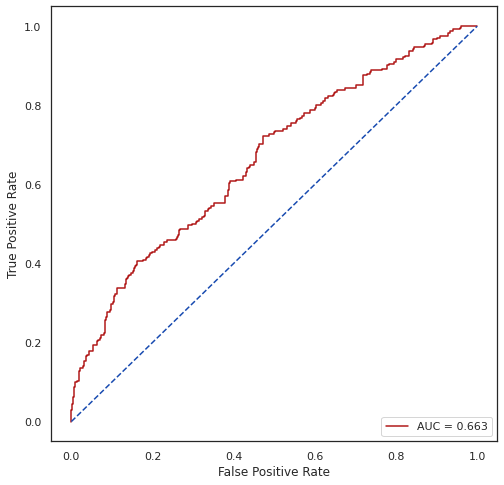

In [38]:
params = study.best_params
params['random_state'] = 228
rf = RandomForestClassifier(**params)
rf.fit(X_train_balanced, Y_train_balanced)
y_pred = rf.predict(X_val)
y_prob = rf.predict_proba(X_val)[:,1]

# Metrics
results.iloc[0, 1] = round(cross_val_score(rf, X_train_balanced, Y_train_balanced, cv = 10, scoring = 'precision').mean(), 2)
results.iloc[1, 1] = round(cross_val_score(rf, X_train_balanced, Y_train_balanced, cv = 10, scoring = 'recall').mean(), 2)
results.iloc[2, 1] = round(cross_val_score(rf, X_train_balanced, Y_train_balanced, cv = 10, scoring = 'f1').mean(), 2)
results.iloc[3, 1] = round(cross_val_score(rf, X_train_balanced, Y_train_balanced, cv = 10, scoring = 'roc_auc').mean(), 3)
rf_cm = confusion_matrix(y_val, y_pred)

print(classification_report(y_val, y_pred))
print(f'ROC AUC score: {round(roc_auc_score(y_val, y_prob), 3)}')
print('')
print('-----------------------------------------------------')
print('')
print('Cross-validation scores with 10 folds:')
print('')
print(f"ROC AUC: {results.iloc[3, 1]}")
print(f"precision: {results.iloc[0, 1]}")
print(f"recall: {results.iloc[1, 1]}")
print(f"f1: {results.iloc[2, 1]}")

# Visualize confusion matrix
plt.figure(figsize = (8, 5))
sns.heatmap(rf_cm, cmap = 'Blues', annot = True, fmt = 'd', linewidths = 5, cbar = False, annot_kws = {'fontsize': 15}, 
            yticklabels = ['Not potable', 'Potable'], xticklabels = ['Predicted not potable', 'Predicted potable'])
plt.yticks(rotation = 0)
plt.show()

# Roc curve
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_val, y_prob)
roc_auc = auc(false_positive_rate, true_positive_rate)

sns.set_theme(style = 'white')
plt.figure(figsize = (8, 8))
plt.plot(false_positive_rate,true_positive_rate, color = '#b01717', label = 'AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], linestyle = '--', color = '#174ab0')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Feature importance
f_imp = pd.DataFrame(columns = ['feature', 'importance'], index = range(9))
for i in range(len(f_imp.index)):
    f_imp.iloc[i, 0] = X_train_balanced.columns.to_list()[i]
f_imp['importance'] = rf.feature_importances_
f_imp = f_imp.sort_values('importance', ascending = False)
f_imp[0:9].style.background_gradient(cmap = 'Blues')

# LGBM

**Optuna with 50 trials and cross-validation with 10 folds to find best parameters.**

In [74]:
def objective(trial, data = X, target = y):

    params = {
        'reg_alpha': trial.suggest_float('reg_alpha', 0.001, 10.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.001, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 10, 500),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'max_depth': trial.suggest_int('max_depth', 2, 6),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 0.6),
        'cat_smooth' : trial.suggest_int('cat_smooth', 10, 100),
        'cat_l2': trial.suggest_int('cat_l2', 1, 20),
        'min_data_per_group': trial.suggest_int('min_data_per_group', 1, 200),
        'n_estimators': trial.suggest_int('n_estimators', 300, 10000),
        'random_state': 228,
        'metric': 'binary_logloss'
    }
    
    model = LGBMClassifier(**params)
    
    return cross_val_score(model, X_train_balanced, Y_train_balanced, cv = 10, scoring = 'accuracy').mean()

study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 50)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Best value:', study.best_value)

[I 2021-07-13 16:08:28,667] A new study created in memory with name: no-name-0fbdb1ed-7ab7-4981-9b02-a0ad73147ba7
[I 2021-07-13 16:08:37,075] Trial 0 finished with value: 0.5956554725871501 and parameters: {'reg_alpha': 9.72901306241416, 'reg_lambda': 0.4117187284938992, 'num_leaves': 411, 'min_child_samples': 42, 'max_depth': 6, 'learning_rate': 0.17881310171220482, 'colsample_bytree': 0.19054676780699495, 'cat_smooth': 60, 'cat_l2': 19, 'min_data_per_group': 137, 'n_estimators': 8158}. Best is trial 0 with value: 0.5956554725871501.
[I 2021-07-13 16:09:03,832] Trial 1 finished with value: 0.6837559397835723 and parameters: {'reg_alpha': 0.29654986133959604, 'reg_lambda': 8.86528219211415, 'num_leaves': 425, 'min_child_samples': 45, 'max_depth': 4, 'learning_rate': 0.12227928092284862, 'colsample_bytree': 0.5657612306346614, 'cat_smooth': 25, 'cat_l2': 4, 'min_data_per_group': 45, 'n_estimators': 4708}. Best is trial 1 with value: 0.6837559397835723.
[I 2021-07-13 16:09:14,047] Trial 

Number of finished trials: 50
Best trial: {'reg_alpha': 1.2215333898349976, 'reg_lambda': 5.041307982808762, 'num_leaves': 402, 'min_child_samples': 10, 'max_depth': 6, 'learning_rate': 0.08016710093373004, 'colsample_bytree': 0.5212091187511816, 'cat_smooth': 71, 'cat_l2': 19, 'min_data_per_group': 197, 'n_estimators': 1879}
Best value: 0.6976460487960707


              precision    recall  f1-score   support

           0       0.71      0.72      0.72       414
           1       0.51      0.50      0.51       242

    accuracy                           0.64       656
   macro avg       0.61      0.61      0.61       656
weighted avg       0.64      0.64      0.64       656

ROC AUC score: 0.649

-----------------------------------------------------

Cross-validation scores with 10 folds:

ROC AUC: 0.77
precision: 0.69
recall: 0.71
f1: 0.7


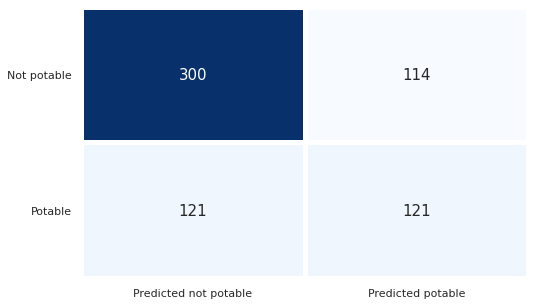

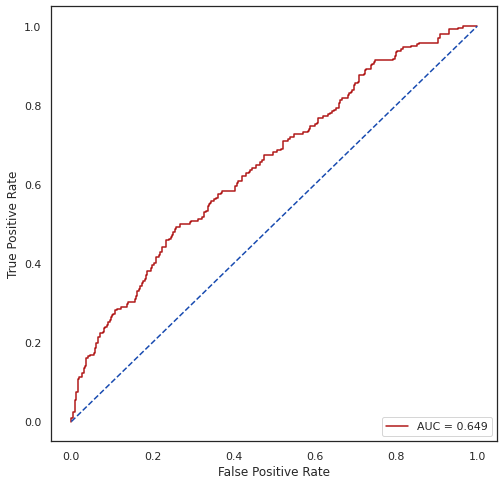

In [75]:
params = study.best_params
params['random_state'] = 228
params['metric'] = 'binary_logloss'
lgbm = LGBMClassifier(**params)
lgbm.fit(X_train_balanced, Y_train_balanced)
y_pred = lgbm.predict(X_val)
y_prob = lgbm.predict_proba(X_val)[:,1]

# Metrics
results.iloc[0, 2] = round(cross_val_score(lgbm, X_train_balanced, Y_train_balanced, cv = 10, scoring = 'precision').mean(), 2)
results.iloc[1, 2] = round(cross_val_score(lgbm, X_train_balanced, Y_train_balanced, cv = 10, scoring = 'recall').mean(), 2)
results.iloc[2, 2] = round(cross_val_score(lgbm, X_train_balanced, Y_train_balanced, cv = 10, scoring = 'f1').mean(), 2)
results.iloc[3, 2] = round(cross_val_score(lgbm, X_train_balanced, Y_train_balanced, cv = 10, scoring = 'roc_auc').mean(), 3)
lgbm_cm = confusion_matrix(y_val, y_pred)

print(classification_report(y_val, y_pred))
print(f'ROC AUC score: {round(roc_auc_score(y_val, y_prob), 3)}')
print('')
print('-----------------------------------------------------')
print('')
print('Cross-validation scores with 10 folds:')
print('')
print(f"ROC AUC: {results.iloc[3, 2]}")
print(f"precision: {results.iloc[0, 2]}")
print(f"recall: {results.iloc[1, 2]}")
print(f"f1: {results.iloc[2, 2]}")

# Visualize confusion matrix
plt.figure(figsize = (8, 5))
sns.heatmap(lgbm_cm, cmap = 'Blues', annot = True, fmt = 'd', linewidths = 5, cbar = False, annot_kws = {'fontsize': 15}, 
            yticklabels = ['Not potable', 'Potable'], xticklabels = ['Predicted not potable', 'Predicted potable'])
plt.yticks(rotation = 0)
plt.show()

# Roc curve
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_val, y_prob)
roc_auc = auc(false_positive_rate, true_positive_rate)

sns.set_theme(style = 'white')
plt.figure(figsize = (8, 8))
plt.plot(false_positive_rate,true_positive_rate, color = '#b01717', label = 'AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], linestyle = '--', color = '#174ab0')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Feature importance
f_imp = pd.DataFrame(columns = ['feature', 'importance'], index = range(9))
for i in range(len(f_imp.index)):
    f_imp.iloc[i, 0] = X_train_balanced.columns.to_list()[i]
f_imp['importance'] = lgbm.feature_importances_
f_imp = f_imp.sort_values('importance', ascending = False)
f_imp[0:9].style.background_gradient(cmap = 'Blues')

# XGB

**Optuna with 50 trials and cross-validation with 10 folds to find best parameters.**

In [78]:
def objective(trial, data = X, target = y):

    params = {
        'max_depth': trial.suggest_int('max_depth', 2, 7),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
        'gamma': trial.suggest_float('gamma', 0.0001, 1.0, log = True),
        'alpha': trial.suggest_float('alpha', 0.0001, 10.0, log = True),
        'lambda': trial.suggest_float('lambda', 0.0001, 10.0, log = True),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 0.6),
        'subsample': trial.suggest_float('subsample', 0.1, 0.6),
        'max_bin': trial.suggest_int('max_bin', 50, 500),
        'n_estimators': trial.suggest_int('n_estimators', 300, 10000),
        'random_state': 2021,
        'objective': 'binary:logistic',
        'eval_metric': 'logloss'
    }
    
    model = XGBClassifier(**params)
    
    return cross_val_score(model, X_train_balanced, Y_train_balanced, cv = 10, scoring = 'accuracy').mean()

study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 50)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Best value:', study.best_value)

[I 2021-07-13 16:23:51,259] A new study created in memory with name: no-name-3837b18f-69ed-4cd7-b4c6-9843713a562c
[I 2021-07-13 16:24:15,516] Trial 0 finished with value: 0.5006309148264985 and parameters: {'max_depth': 6, 'learning_rate': 0.10583947228287734, 'min_child_weight': 243, 'gamma': 0.3611566544541305, 'alpha': 0.00010720766043728543, 'lambda': 0.05415734991703515, 'colsample_bytree': 0.3808230367791712, 'subsample': 0.526001378493616, 'max_bin': 76, 'n_estimators': 4831}. Best is trial 0 with value: 0.5006309148264985.
[I 2021-07-13 16:24:19,473] Trial 1 finished with value: 0.5498991734217146 and parameters: {'max_depth': 6, 'learning_rate': 0.027447857787018526, 'min_child_weight': 43, 'gamma': 0.15263861052019037, 'alpha': 0.00018059469255768545, 'lambda': 0.002126150251010148, 'colsample_bytree': 0.19166569303585282, 'subsample': 0.20656659890095588, 'max_bin': 156, 'n_estimators': 613}. Best is trial 1 with value: 0.5498991734217146.
[I 2021-07-13 16:25:03,185] Trial 2

Number of finished trials: 50
Best trial: {'max_depth': 6, 'learning_rate': 0.03673139531631349, 'min_child_weight': 1, 'gamma': 0.0002959092381844131, 'alpha': 0.053864495416131905, 'lambda': 0.0002554139674140689, 'colsample_bytree': 0.5871211966878332, 'subsample': 0.5002158655278023, 'max_bin': 147, 'n_estimators': 4292}
Best value: 0.6916523579443357


              precision    recall  f1-score   support

           0       0.69      0.72      0.70       414
           1       0.48      0.45      0.47       242

    accuracy                           0.62       656
   macro avg       0.59      0.58      0.58       656
weighted avg       0.61      0.62      0.62       656

ROC AUC score: 0.617

-----------------------------------------------------

Cross-validation scores with 10 folds:

ROC AUC: 0.762
precision: 0.68
recall: 0.71
f1: 0.7


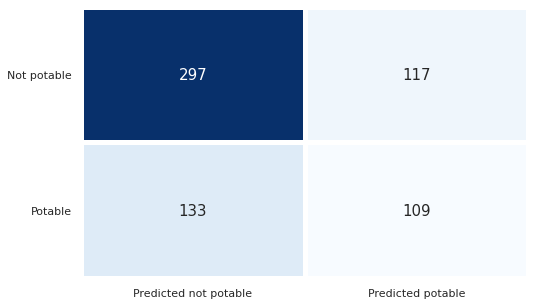

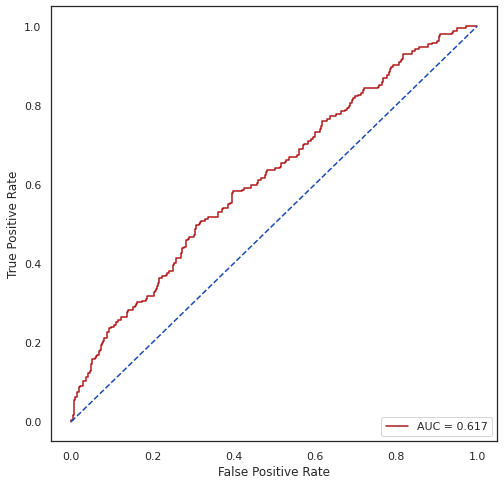

In [79]:
params = study.best_params
params['random_state'] = 2021
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
xgb = XGBClassifier(**params)
xgb.fit(X_train_balanced, Y_train_balanced)
y_pred = xgb.predict(X_val)
y_prob = xgb.predict_proba(X_val)[:,1]

# Metrics
results.iloc[0, 3] = round(cross_val_score(xgb, X_train_balanced, Y_train_balanced, cv = 10, scoring = 'precision').mean(), 2)
results.iloc[1, 3] = round(cross_val_score(xgb, X_train_balanced, Y_train_balanced, cv = 10, scoring = 'recall').mean(), 2)
results.iloc[2, 3] = round(cross_val_score(xgb, X_train_balanced, Y_train_balanced, cv = 10, scoring = 'f1').mean(), 2)
results.iloc[3, 3] = round(cross_val_score(xgb, X_train_balanced, Y_train_balanced, cv = 10, scoring = 'roc_auc').mean(), 3)
xgb_cm = confusion_matrix(y_val, y_pred)

print(classification_report(y_val, y_pred))
print(f'ROC AUC score: {round(roc_auc_score(y_val, y_prob), 3)}')
print('')
print('-----------------------------------------------------')
print('')
print('Cross-validation scores with 10 folds:')
print('')
print(f"ROC AUC: {results.iloc[3, 3]}")
print(f"precision: {results.iloc[0, 3]}")
print(f"recall: {results.iloc[1, 3]}")
print(f"f1: {results.iloc[2, 3]}")

# Visualize confusion matrix
plt.figure(figsize = (8, 5))
sns.heatmap(xgb_cm, cmap = 'Blues', annot = True, fmt = 'd', linewidths = 5, cbar = False, annot_kws = {'fontsize': 15}, 
            yticklabels = ['Not potable', 'Potable'], xticklabels = ['Predicted not potable', 'Predicted potable'])
plt.yticks(rotation = 0)
plt.show()

# Roc curve
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_val, y_prob)
roc_auc = auc(false_positive_rate, true_positive_rate)

sns.set_theme(style = 'white')
plt.figure(figsize = (8, 8))
plt.plot(false_positive_rate,true_positive_rate, color = '#b01717', label = 'AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], linestyle = '--', color = '#174ab0')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Feature importance
f_imp = pd.DataFrame(columns = ['feature', 'importance'], index = range(9))
for i in range(len(f_imp.index)):
    f_imp.iloc[i, 0] = X_train_balanced.columns.to_list()[i]
f_imp['importance'] = xgb.feature_importances_
f_imp = f_imp.sort_values('importance', ascending = False)
f_imp[0:9].style.background_gradient(cmap = 'Blues')

# Results and conclusion

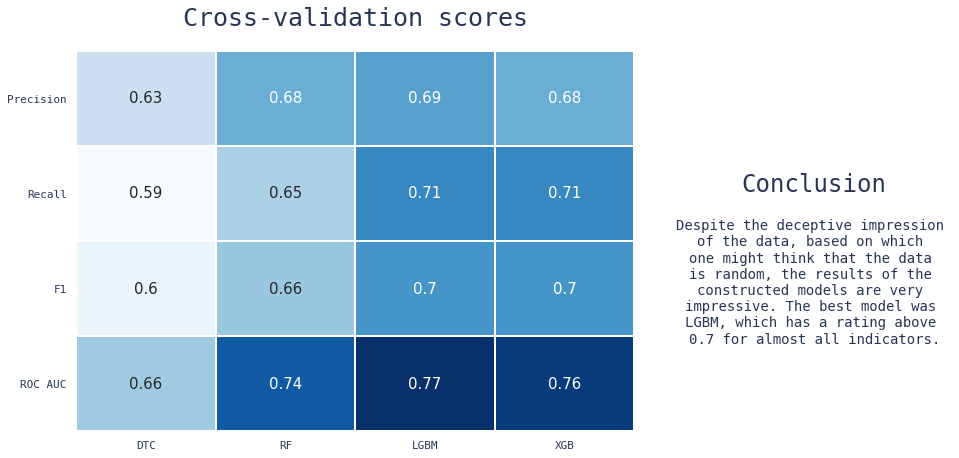

In [80]:
plt.figure(figsize = (10, 7))
plt.title('Cross-validation scores', size = 25, y = 1.05, fontname = 'monospace', color = '#283655')
sns.heatmap(results[results.columns.to_list()].astype(float), cmap = 'Blues', annot = True, linewidths = 1.5, cbar = False, annot_kws = {'fontsize': 15},
           yticklabels = ['Precision', 'Recall', 'F1', 'ROC AUC'])
sns.set(font_scale = 1.5)
plt.xticks(fontname = 'monospace', color = '#283655')
plt.yticks(rotation = 0, fontname = 'monospace', color = '#283655')

plt.figtext(1.15, 0.6, 'Conclusion', fontsize = 24, fontname = 'monospace', color = '#283655', ha = 'center')
plt.figtext(1.15, 0.3, '''Despite the deceptive impression 
of the data, based on which 
one might think that the data 
is random, the results of the 
constructed models are very 
impressive. The best model was 
LGBM, which has a rating above 
0.7 for almost all indicators.''', fontsize = 14, fontname = 'monospace', color = '#283655', ha = 'center')

plt.show()

**And yet I have a lot of questions about the quality of this data, not water. In any case, I am impressed with the results. And this was not the best way to tune models.**